<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import json
import os
import numpy as np
from json2table import convert
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import math
import tabulate
import pandas as pd

In [16]:
def load_run(path):
    # load info.json
    with open(os.path.join(path, 'info.json'), 'r') as f:
        info = json.load(f)
    return info

def od_matrix_error(targets, predictions):    
    
    diff = np.subtract(targets,predictions)
    error_abs_samples = np.sum(np.abs(diff)**2,axis=-1)**(1./2)

    mean_error_abs = np.mean(error_abs_samples)
    min_error_abs = np.min(error_abs_samples)
    max_error_abs = np.max(error_abs_samples)
    std_error_abs = np.std(error_abs_samples)
    
    # Compute relative errors by normalizing with the current 
    # pedestrian count of the ground truth od matrix
    ped_count = np.sum(targets, axis=1)
    error_rel_samples = np.divide(error_abs_samples, ped_count)
    
    mean_error_rel = np.mean(error_rel_samples)
    min_error_rel = np.min(error_rel_samples)
    max_error_rel = np.max(error_rel_samples)
    std_error_rel = np.std(error_rel_samples)
    
    abs_errors = {'mean error' : mean_error_abs, 'min error' : min_error_abs, 'max error' : max_error_abs, 'std error': std_error_abs}
    rel_erros = {'mean error' : mean_error_rel, 'min error' : min_error_rel, 'max error' : max_error_rel, 'std error' : std_error_rel}
    
    return {'abs error' : abs_errors, \
            'abs error per sample': error_abs_samples, \
            'rel error per sample': error_rel_samples, \
            'rel error':rel_erros}

def get_errors_scores(run_dir, k_runs):
    # mean, min, max, std, train, test, oob
    errors_abs = np.zeros((len(k_runs),4))
    errors_rel = np.zeros((len(k_runs),4))
    scores_rf = np.zeros((len(k_runs),3))
    
    for i, run in enumerate(k_runs):
        df = pd.read_csv(os.path.join(run_dir,run, 'predictions.csv'))
        info = load_run(os.path.join(run_dir, run))

        scores_rf[i, 0] = info['error']['training_score']['value']
        scores_rf[i, 1] = info['error']['test_score']['value']
        scores_rf[i, 2] = info['error']['oob_score']['value']

        dfs = np.split(df, [number_of_targets], axis=1)
        predictions = dfs[0]
        ground_truth = dfs[1]

        samples_p = np.array(predictions.values.tolist())
        samples_t = np.array(ground_truth.values.tolist())

        error_dict = od_matrix_error(samples_t, samples_p)
        index = 0
        for key in error_dict['abs error']:
            errors_abs[i, index] = error_dict['abs error'][key]
            index+=1

        index = 0
        for key in error_dict['rel error']:
            errors_rel[i, index] = error_dict['rel error'][key]
            index+=1
        
    return error_dict, errors_abs, errors_rel, scores_rf, samples_p, samples_t

def error_plot(errors, run_indexes, xticks, error_type):
    
    for i in range(0,2):
        ax[i].set_xticks(run_indexes, run_type)
        ax[i].set_title('{0} Errors'.format(error_type[i]))
        ax[i].set_xlabel('runs')
        ax[i].set_ylabel('{0} errors'.format(error_type[i]))
        ax[i].scatter(run_indexes, errors[i][:,0], c='g', label='mean')
        ax[i].scatter(run_indexes, errors[i][:,1], c='b', label='min')
        ax[i].scatter(run_indexes, errors[i][:,2], c='r', label='max')
        ax[i].scatter(run_indexes, errors[i][:,3], c='c', label='std')
        ax[i].set_xticks(run_indexes)
        ax[i].set_xticklabels(xticks)
        ax[i].grid()
        ax[i].legend()
    
def score_plot(scores_rf, run_indexes, xticks,title):
    plt.title(title)
    plt.scatter(run_indexes, scores_rf[:,0], c='r', label='train score')
    plt.scatter(run_indexes, scores_rf[:,1], c='b', label='test score')
    plt.scatter(run_indexes, scores_rf[:,2], c='g', label='oob score')
    plt.xlabel("runs")
    plt.ylabel("scores")
    plt.grid()
    plt.legend()
    plt.ylim([0,1.5])
    plt.xlim([-0.5,len(run_indexes)])
    plt.xticks(run_indexes, xticks)
    
    
def sample_error_bar_plot(error_per_sample, error_type, predictions, ground_truth):
    num_samples = np.shape(error_per_sample)[0]
    plt.title("{0} error per sample compared to pedestrian count ".format(error_type))
    ped_count_p = np.sum(predictions,axis=1)
    ped_count_t = np.sum(ground_truth, axis=1)
    
    labels = [str(s) for s in range(1,num_samples)]
    
    x = np.arange(num_samples)
    width=0.2
    
    #fig, ax = plt.subplots()
    #rects1 = ax.bar(x-width/2, error_per_sample,width, label='error per sample')
    #rects2 = ax.bar(x+width/2, ped_count_t,width, label='pedestrian count')
    
    #ax.set_ylabel('Error/Pedestrian Count')
    #ax.set_title("Error per sample vs. current pedestrian count")
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    #ax.legend()
    #fig.tight_layout()
    
    #plt.show()
    
    plt.plot(x,error_per_sample,label='error_abs')
    plt.plot(x,ped_count_t,label='ped_count_truth')
    plt.plot(x,ped_count_p,label='ped_count_pred')
    plt.ylabel("Pedestrians")
    plt.xlabel("test samples")
    plt.legend()
    

## k-fold validation using baseline dataset (dataset1)

['2020-2-5_22-48-23', '2020-2-5_10-9-20', '2020-2-5_21-26-4', '2020-2-5_8-44-13', '2020-2-5_20-44-29', '2020-2-5_9-26-52', '2020-2-5_23-29-37', '2020-2-5_22-7-27', '2020-2-5_10-51-5', '2020-2-5_11-32-12']


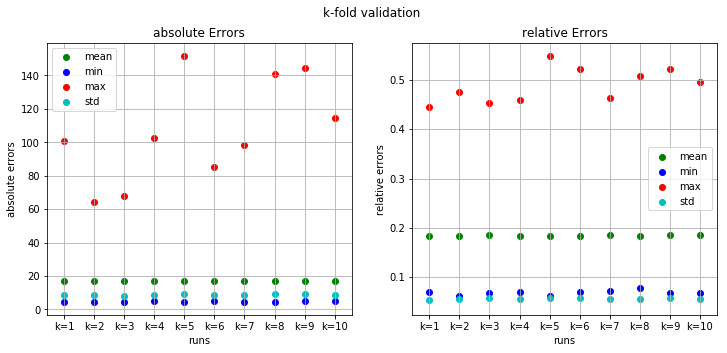

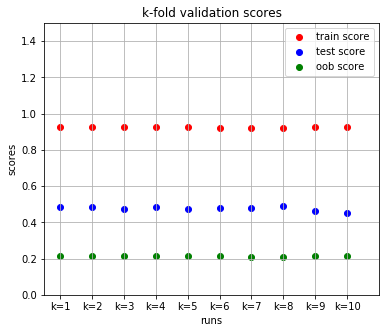

mean error,min error,max error,std error
17.20108103238972,5.010788361126421,114.36516777410857,8.883843665482987


mean error,min error,max error,std error
0.1862114268857508,0.06819519603867562,0.4962068961790316,0.05610586031991747


In [17]:
plt.rcParams['figure.figsize'] = [6, 5]
basedir = os.getcwd()

number_of_targets = 54
run_dir = os.path.join(basedir, "../python/python_src_preprocessing/runs/sbb/k-fold/")
k_runs = os.listdir(run_dir)
print(k_runs)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
fig.suptitle("title")

error_dict, errors_abs, errors_rel, scores_rf, samples_p, samples_t = get_errors_scores(run_dir, k_runs)        

run_indexes = list(range(0,len(k_runs)))
run_type = ['k={0}'.format(i) for i in range(1,len(k_runs)+1)]

# plot abs and rel errors
fig.suptitle("k-fold validation")
error_plot([errors_abs, errors_rel], run_indexes, run_type, ['absolute','relative'])
plt.show()
# plot scores read from the file info.json
score_plot(scores_rf, run_indexes, run_type,"k-fold validation scores")
plt.show()

html = convert(error_dict['abs error'], build_direction='TOP_TO_BOTTOM')
display(HTML(html))
html = convert(error_dict['rel error'], build_direction='TOP_TO_BOTTOM')
display(HTML(html))


### Histograms of absolute and relative errors per sample

In [ ]:
plt.hist(error_dict['abs error per sample'], bins='auto') 
plt.title("Histogram of absolute errors L2 norm |targets-predictions|")
plt.xlabel("absolute L2 error per sample")
plt.ylabel("Frequency")
plt.savefig("hist_abs_error_run_2020-2-2_23-2-10.png",dpi=400)
plt.show()

plt.hist(error_dict['rel error per sample'], bins='auto') 
plt.title("Histogram of absolute errors L2 norm |targets-predictions|")
plt.xlabel("relative L2 error per sample")
plt.ylabel("Frequency")
plt.savefig("hist_rel_error_run_2020-2-2_23-2-10.png",dpi=400)
plt.show()

## Comparison of different optimization options

- differencing
- number of trees

still missing:
- PCA
- LLP
- box-cox
- other parameter optimization: m, max_depth, min_samples

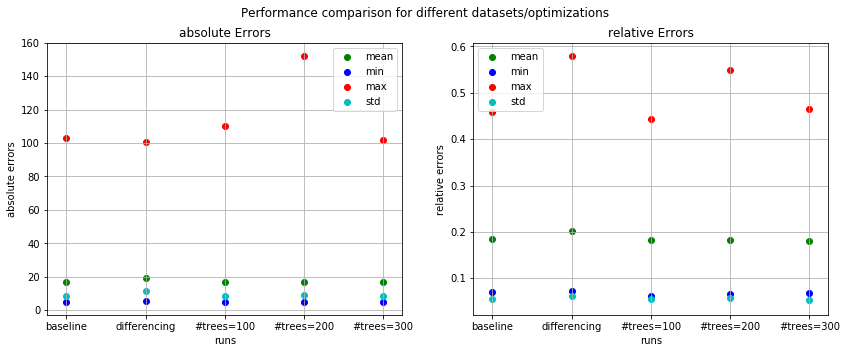

number of test samples 1846


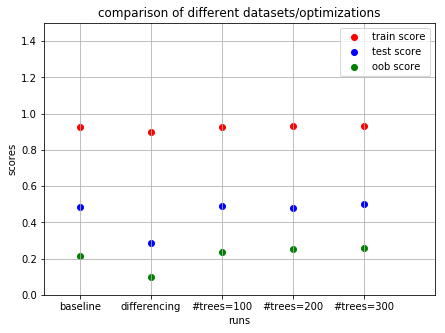

In [22]:

basedir = os.getcwd()
number_of_targets = 54
run_dir = os.path.join(basedir, "../python/python_src_preprocessing/runs/sbb/")
k_runs =  ['k-fold/2020-2-5_8-44-13','2020-2-12_10-38-33','2020-2-12_14-26-12','2020-2-16_22-23-51','2020-2-17_0-44-47'] #
run_type = ['baseline','differencing','#trees=100','#trees=200','#trees=300']


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 5))
fig.suptitle("title")

error_dict, errors_abs, errors_rel, scores_rf,pred,truth = get_errors_scores(run_dir, k_runs)
        
# error plots 
run_indexes = list(range(0,len(k_runs)))
fig.suptitle("Performance comparison for different datasets/optimizations")
error_plot([errors_abs,errors_rel], run_indexes, run_type, ['absolute','relative'])
plt.savefig("different_runs_errors.png",dpi=500)
plt.show()
# score plots
plt.rcParams['figure.figsize'] = [7, 5]
score_plot(scores_rf,run_indexes,run_type,"comparison of different datasets/optimizations")
plt.savefig("different_runs_scores.png",dpi=500)

rel_per_sample = error_dict['abs error per sample']
print("number of test samples",len(rel_per_sample))
plt.show()

#plt.show()

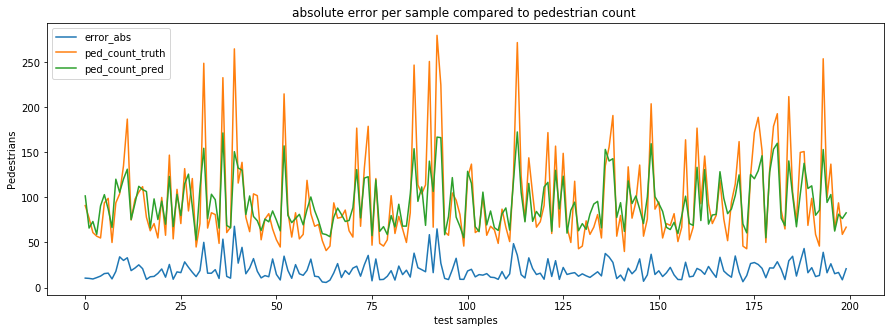

In [8]:
#plt.rcParams['figure.figsize'] = [15, 5]
sample_error_bar_plot(rel_per_sample[0:200], 'absolute', pred[0:200,:], truth[0:200,:])
plt.savefig("abs_error_per_sample_vs_ped_count_samples_0_to_200.png", dpi=500)